In [1]:
# Just a mess of imports. Much more to come.

import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Added the encoding because I was getting an error. Don't know about you.

data = pd.read_csv('data.csv', encoding = "ISO-8859-1")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
data.iloc[0,0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [7]:
data[data.isna().any(axis=1)]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [8]:
data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
# Simplify

company = {'iPad': 'Apple',
            'Apple': 'Apple',
            'iPad or iPhone App': 'Apple',
            'Google': 'Google',
            'iPhone': 'Apple',
            'Other Google product or service': 'Google',
            'Android App': 'Google',
            'Android': 'Google',
            'Other Apple product or service': 'Apple'}
data['emotion_in_tweet_is_directed_at'] = data['emotion_in_tweet_is_directed_at'].map(company)

In [10]:
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [11]:
print(data['tweet_text'].isna().sum())

data = data[~data['tweet_text'].isna()]

1


In [12]:
# Simplify column names

data.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'brand', 'is_there_an_emotion_directed_at_a_brand_or_product': 'feelings'}, inplace=True)

In [13]:
###################### Simplify for now to create base model. Afterwards, may revisit. #####################

data.drop(data[data['feelings'] == "I can't tell"].index, inplace = True)

In [14]:
# Encode labels

feels = {'Negative emotion': 0,
        'Positive emotion': 1,
        'No emotion toward brand or product': 2}

data['feelings'] = data['feelings'].map(feels)

In [15]:
len(data)

8936

In [16]:
###################### Simplify for now to create base model. Afterwards, definitely revisit. #####################

data = data[data['feelings'] <= 1]

In [17]:
len(data)

3548

In [18]:
X = data['text'].map(word_tokenize)
target = data['feelings']

In [19]:
tokenizer = RegexpTokenizer(r'\w+')
hashtag = RegexpTokenizer(r'\#\w+')

In [20]:
data

,text,brand,feelings
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Apple,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Apple,1
9080,Diller says Google TV &quot;might be run over ...,Google,0
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,1


In [21]:
stops = stopwords.words('english')
stops += list(string.punctuation)
stops.extend(['sxsw', 'sxswi', 'quot', 'mention', 'link', 'rt', 'amp', 'http', 'sxswrt', 'google', 'googles', 'app', 'apps', 'android', 'austin', 'quotgoogle', 'new', 'today', 'one', 'apple', 'ipad', 'iphone', 'ipad2', 'apples', 'quotapple', 'store'])

In [22]:
a = len(data)
data = data.drop_duplicates()
b = len(data)
print('# Number of duplicate rows dropped: {}'.format(a-b))

# Number of duplicate rows dropped: 9


In [23]:
data['tokens'] = data['text'].apply(tokenizer.tokenize)
data['hash'] = data['text'].apply(hashtag.tokenize)
data

,text,brand,feelings,tokens,hash
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...","[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,"[jessedee, Know, about, fludapp, Awesome, iPad...",[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,"[swonderlin, Can, not, wait, for, iPad, 2, als...","[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,"[sxsw, I, hope, this, year, s, festival, isn, ...",[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",[#SXSW]
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Apple,1,"[mention, your, PR, guy, just, convinced, me, ...","[#sxsw, #princess]"
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Apple,1,"[quot, papyrus, sort, of, like, the, ipad, quo...",[#SXSW]
9080,Diller says Google TV &quot;might be run over ...,Google,0,"[Diller, says, Google, TV, quot, might, be, ru...","[#sxsw, #diller]"
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,1,"[I, ve, always, used, Camera, for, my, iPhone,...","[#SXSW, #SXSWi]"


In [24]:
data['tokens'] = data['tokens'].apply(lambda x: [word.lower() for word in x if word not in stops])
data['tokens'] = data['tokens'].apply(lambda x: [word.lower() for word in x if word not in stops])

In [25]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    try:
        return [lemmatizer.lemmatize(w) for w in text]
    except:
        print(text)

data['lemm'] = data['tokens'].apply(lemmatize_text)
data['lemm'] = data['lemm'].apply(lambda x: ' '.join(x))
data ['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))

In [26]:
print('Lemmatized changed this many rows:', (len(data) - (sum(data['tokens'] == data['lemm']))))

Lemmatized changed this many rows: 1925


In [27]:
data

,text,brand,feelings,tokens,hash,lemm
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,wesley83 3g 3 hrs tweeting rise_austin dead ne...,"[#RISE_Austin, #SXSW]",wesley83 3g 3 hr tweeting rise_austin dead nee...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,jessedee know fludapp awesome likely appreciat...,[#SXSW],jessedee know fludapp awesome likely appreciat...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,swonderlin wait 2 also sale,"[#iPad, #SXSW]",swonderlin wait 2 also sale
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,hope year festival crashy year,[#sxsw],hope year festival crashy year
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff fri marissa mayer tim re...,[#SXSW],sxtxstate great stuff fri marissa mayer tim re...
...,...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Apple,1,pr guy convinced switch back great coverage pr...,"[#sxsw, #princess]",pr guy convinced switch back great coverage pr...
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Apple,1,papyrus sort like nice lol lavelle,[#SXSW],papyrus sort like nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Google,0,diller says tv might run playstation xbox esse...,"[#sxsw, #diller]",diller say tv might run playstation xbox essen...
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,1,always used camera b c image stabilizer mode s...,"[#SXSW, #SXSWi]",always used camera b c image stabilizer mode s...


In [28]:
################ CHANGE BELOW TO TF IDF ####################

In [29]:
smote = SMOTE()


################# For Lemmatizing
X_train, X_test, y_train, y_test = train_test_split(data['lemm'], data['feelings'])

################# For CountVectorizing
# X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data['feelings'])

tfidf = TfidfVectorizer()

X_train_counts = tfidf.fit_transform(X_train)
X_test_counts = tfidf.transform(X_test)

X_train_counts, y_train = smote.fit_sample(X_train_counts, y_train)

print(Counter(y_train))

Counter({1: 2234, 0: 2234})


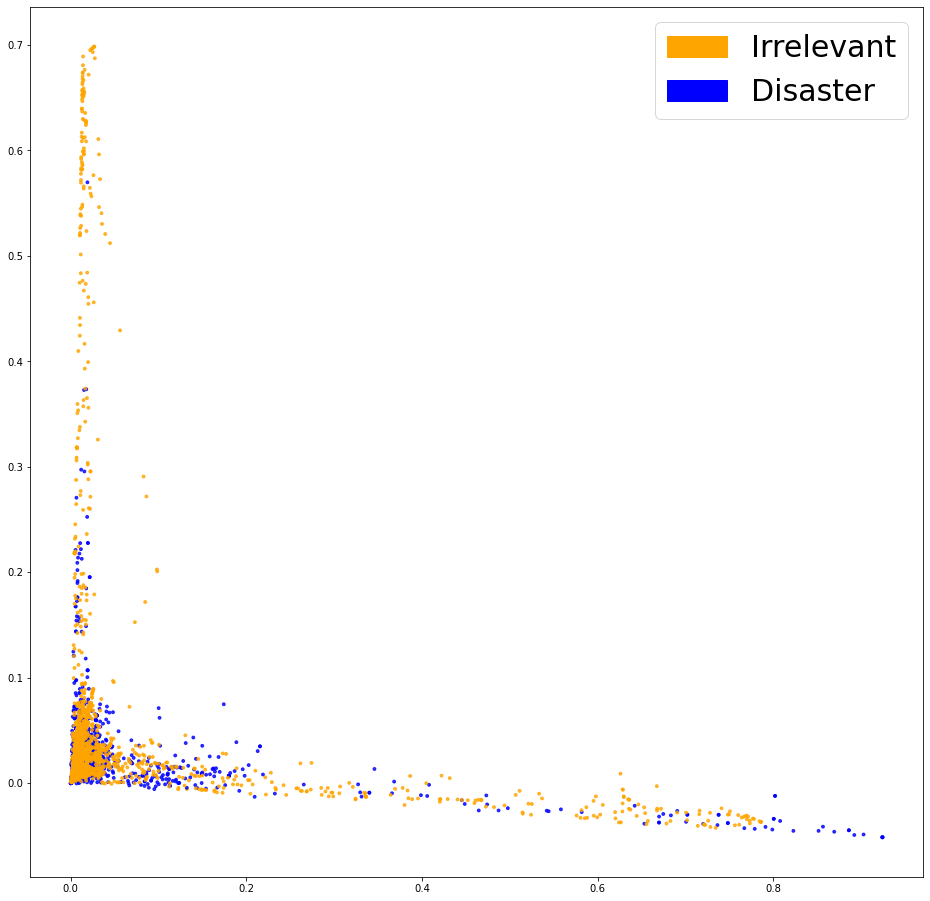

In [30]:
# Straight up stolen code, tweak to needs later or discard because it's useless
# Haven't bothered changing labels because the graph isn't useful for our purposes

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [31]:


clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [32]:


def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.866, precision = 0.855, recall = 0.866, f1 = 0.859


In [33]:
confusion_matrix(y_test, y_predicted_counts)

array([[ 73,  76],
       [ 43, 693]], dtype=int64)

In [34]:
print('Classification Report - TEST')
print('--------------------------------------------------------------------------')
print(classification_report(y_test, y_predicted_counts))
# Confusion Matrix
print('--------------------------------------------------------------------------')
print('Confusion Matrix - TEST')
print('--------------------------------------------------------------------------')
print(pd.crosstab(y_test, y_predicted_counts, rownames=['True'], colnames=['Predicted'], margins=True))
print('--------------------------------------------------------------------------')

Classification Report - TEST
--------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       149
           1       0.90      0.94      0.92       736

    accuracy                           0.87       885
   macro avg       0.77      0.72      0.74       885
weighted avg       0.86      0.87      0.86       885

--------------------------------------------------------------------------
Confusion Matrix - TEST
--------------------------------------------------------------------------
Predicted    0    1  All
True                    
0           73   76  149
1           43  693  736
All        116  769  885
--------------------------------------------------------------------------


In [35]:
rf = RandomForestClassifier()
rf.fit(X_train_counts, y_train)

y_predicted_counts = rf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.876, precision = 0.869, recall = 0.876, f1 = 0.854


In [36]:
confusion_matrix(y_test, y_predicted_counts)

array([[ 51,  98],
       [ 12, 724]], dtype=int64)

In [37]:
print('Classification Report - TEST')
print('--------------------------------------------------------------------------')
print(classification_report(y_test, y_predicted_counts))
# Confusion Matrix
print('--------------------------------------------------------------------------')
print('Confusion Matrix - TEST')
print('--------------------------------------------------------------------------')
print(pd.crosstab(y_test, y_predicted_counts, rownames=['True'], colnames=['Predicted'], margins=True))
print('--------------------------------------------------------------------------')

Classification Report - TEST
--------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.34      0.48       149
           1       0.88      0.98      0.93       736

    accuracy                           0.88       885
   macro avg       0.85      0.66      0.71       885
weighted avg       0.87      0.88      0.85       885

--------------------------------------------------------------------------
Confusion Matrix - TEST
--------------------------------------------------------------------------
Predicted   0    1  All
True                   
0          51   98  149
1          12  724  736
All        63  822  885
--------------------------------------------------------------------------


In [60]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = tfidf.get_feature_names(),
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.tail(25)
feature_importances

,importance
fail,0.017875
headache,0.014798
battery,0.014496
long,0.013630
need,0.011733
...,...
pg,0.000000
performance,0.000000
perfectly,0.000000
percentage,0.000000


In [41]:
X_train_counts

<4468x4643 sparse matrix of type '<class 'numpy.float64'>'
	with 44548 stored elements in Compressed Sparse Row format>

In [49]:
# def plot_feature_importances(model):
#     n_features = X_train.shape[1]
#     plt.figure(figsize=(12,20))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), X_train.columns.values) 
#     plt.xlabel('Feature importance')
#     plt.ylabel('Feature')
# plot_feature_importances(rf)

IndexError: tuple index out of range

In [48]:
# importance = pd.DataFrame(data={'features': pd.DataFrame(X_train_counts).columns, 'importance': rf.feature_importances_})
# importance = importance.sort_values('importance', ascending=False)
# importance = importance.reset_index()
# importance.drop('index', axis=1, inplace=True)
# importance.head(10)

ValueError: arrays must all be same length

In [ ]:
rf.get_params()

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [65, 70, 75],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3, 4, 5],
    'n_estimators': [55, 60, 65]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='recall', 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_counts, y_train)

y_predicted_counts = grid_search.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [ ]:
confusion_matrix(y_test, y_predicted_counts)

In [ ]:
print('Classification Report - TEST')
print('--------------------------------------------------------------------------')
print(classification_report(y_test, y_predicted_counts))
# Confusion Matrix
print('--------------------------------------------------------------------------')
print('Confusion Matrix - TEST')
print('--------------------------------------------------------------------------')
print(pd.crosstab(y_test, y_predicted_counts, rownames=['True'], colnames=['Predicted'], margins=True))
print('--------------------------------------------------------------------------')

In [ ]:
nb = MultinomialNB()

In [ ]:
nb.fit(X_train_counts, y_train)

y_predicted_counts = nb.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [ ]:
confusion_matrix(y_test, y_predicted_counts)

In [ ]:
print('Classification Report - TEST')
print('--------------------------------------------------------------------------')
print(classification_report(y_test, y_predicted_counts))
# Confusion Matrix
print('--------------------------------------------------------------------------')
print('Confusion Matrix - TEST')
print('--------------------------------------------------------------------------')
print(pd.crosstab(y_test, y_predicted_counts, rownames=['True'], colnames=['Predicted'], margins=True))
print('--------------------------------------------------------------------------')

In [ ]:
# 1. tf-idf
# 2. SMOTE
# 3. Lemmatize
# 4. Bigrams + Trigrams